# Tutorial de reconstrucción de lente

In [17]:
import cmb_modulos

In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
# Usamos algunas cosas que aprendimos antes
from cmb_modulos import calcular_espectro_2d, crear_mapa_CMB_T
import lens_modules as lm
np.random.seed(100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


En este tutorial, aprenderemos cómo obtener la convergencia de lentes subyacente, es decir, la densidad de materia oscura proyectada, a partir de un mapa observado de CMB. Primero simularemos un mapa de CMB con-lente como aprendimos en un tutorial anterior.

In [19]:
tamaño_parche_grados = 40. # ancho del parche en grados
tamaño_pix = 1.5 # tamaño de píxel en arcominutos
ells,ucltt,lcltt,clkk = lm.get_theory()
N,lensed,kappa,ly,lx,modlmap = lm.get_lensed(tamaño_parche_grados,tamaño_pix,ells,ucltt,clkk)

Convolucionemos ahora este mapa con el haz y agreguemos ruido.

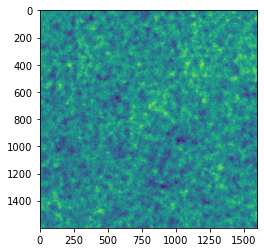

In [20]:
# Haz
haz_fwhm = 1.4
def haz_gauss(ell,fwhm):
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))
khaz2d = haz_gauss(modlmap,haz_fwhm)
mapaconhaz = lm.filter_map(lensed,khaz2d)

# Ruido
ruido_uk_arcmin = 1.5
# Ruido blanco
Clruido = (ruido_uk_arcmin*np.pi/180./60.)**2.
Dlruido = Clruido*ells*(ells+1.)/2./np.pi
# Hacer una realización gaussiana
mapa_ruido = crear_mapa_CMB_T(N,tamaño_pix,ells,Dlruido)

# El mapa observado
observado = mapaconhaz + mapa_ruido

plt.imshow(observado)
plt.show()

## Reconstrucción de lente

$\newcommand{\vect}[1]{\boldsymbol{\mathbf{#1}}}$
$\newcommand{\al}{\mathbf{\alpha}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\nab}{\mathbf{\nabla}}$
$\newcommand{\uT}{{\tilde{T}}}$
$\newcommand{\uC}{{\tilde{C}}}$
$\newcommand{\dphi}{{\nab\phi}}$
$\newcommand{\O}{{\mathcal{O}}}$
$\newcommand{\l}{{\mathbf{\ell}}}$
$\newcommand{\L}{{\mathbf{L}}}$

Expandamos la ecuación de lentes:

$$
T(\x) = \uT(\x+\al)
$$

en una serie de Taylor (y sustituyendo $\al=\dphi$) en el límite de lentes débiles con $\phi$ pequeño,

$$
T(\x) \approx \uT(\x) + \nabla \uT \cdot \dphi + \O(\dphi^2)
$$ 

EJERCICIO: Utilizando transformadas de Fourier 2D,

$$
X(\l) = \int d^2\x ~e^{-i\l\cdot\x}X(\x)
$$
$$
X(\x) = \int \frac{d^2\l}{(2\pi)^2} ~e^{i\l\cdot\x}X(\l)
$$
$$
\int d^2\x e^{i\l\cdot\x} = (2\pi)^2 \delta(\l)
$$

demuestra que, en el primer orden del potencial de lentes, el efecto de lentes induce un acoplamiento entre los modos del mapa de CMB:

$$
\langle T(\l_1)T(\l_2) \rangle_{\rm CMB} = \phi(\L)\left[\uC^{TT}_{\ell_1}(\L \cdot \l_1) + \uC^{TT}_{\ell_2}(\L \cdot \l_2)\right]
$$

donde el promedio se realiza sobre realizaciones del campo de CMB no lenseado $\uT$. El resultado anterior motiva extraer los modos del potencial de lentes $\phi(\L)$ mediante un promedio ponderado de productos de modos de CMB. Los pesos pueden ser derivados de manera que se minimice el ruido en la reconstrucción. El estimador resultante es:

$$
\hat{\kappa}(\L) = -A(\L) \int d^2\l_1 \left[\uC^{TT}_{\ell_1}(\L \cdot \l_1) + \uC^{TT}_{\ell_2}(\L \cdot \l_2)\right]\frac{T(\l_1)T(\l_2)}{C^{TT}_{\ell_1}C^{TT}_{\ell_2}}
$$

EJERCICIO: Demuestra que el estimador anterior puede ser escrito como una multiplicación en espacio real:

$$
\hat{\kappa} \propto -\nabla \cdot \left[\left(\nabla T_W\right) T_H \right]
$$

Donde $T_W$ es el mapa de temperatura con un filtro de Wiener dado por $\frac{\uC^{TT}_{\ell}}{C^{TT}_{\ell}}$ y $T_H$ es el mapa de temperatura filtrado por la inversa de la varianza, $\frac{1}{C^{TT}_{\ell}}$.

In [4]:
# Ahora intentamos reconstruir un mapa de lentes a partir del mapa observado.
def qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx):
    """
    La forma más simple del estimador cuadrático es

    kappa_recon = - div (grad(T) T )
    donde grad(T) es Wiener filtrado con (unlensed_cmb_power/total_cmb_power)
    y T se filtra con (1/total_cmb_power)
    donde el mapa T es convolucionado con el haz y 
    donde total_cmb_power = lensed_cmb_power + noise_power / beam^2

    La reconstrucción se limita a ellmin < ells < ellmax del mapa de temperatura CMB.

    Las operaciones grad y div requieren conocimientos de:
    modlmap: números de onda absolutos de píxeles de Fourier
    ly: mapa de la coordenada ly de Fourier de cada píxel
    lx: mapa de la coordenada lx de Fourier de cada píxel
    (nota modlmap = sqrt(ly**2 + lx**2)
    """
    inv_noise_filter = lm.kmask((1./total_cmb_power_2d),modlmap,ellmin,ellmax)
    grad_filter = lm.kmask((unlensed_cmb_power_2d/total_cmb_power_2d),modlmap,ellmin,ellmax)

    gradTy,gradTx = lm.gradient(tmap,ly,lx)

    # Grad(T_G) Wiener filtrado 
    filtered_gradTy = lm.filter_map(gradTy,grad_filter)
    filtered_gradTx = lm.filter_map(gradTx,grad_filter)
    # La varianza inversa filtrada T_H
    
    # TH filtrado por la varianza inversa
    filtered_T = lm.filter_map(tmap,inv_noise_filter)
    
    ############## COMPLETAR ESTO!!!
    # AGREGA UNA LINEA ACÁ ABAJO PARA OBTENER ukappa = divergence(Grad(T_G) * T_H)
    
    ############## COMPLETAR ESTO!!!
    
    # Filtramos con 1/L^2 al final para blanquear la normalización
    return -lm.filter_map(ukappa,lm.kmask(1/modlmap**2,modlmap,ellmin=2))

# Para esto también necesitamos saber cómo calcular una divergencia
def div(imapy,imapx,ly,lx):
    # Retorna divergencia grad(Y)_y + grad(X)_x
    ############## COMPLETAR ESTO!!!
    # COMPLETE THIS FUNCTION THAT RETURNS THE DIVERGENCE
    ############## COMPLETAR ESTO!!!
    return divergence


def interp(x,y,bounds_error=False,fill_value=0.,**kwargs):
    # Interpolador simple que se llena con ceros por defecto
    from scipy.interpolate import interp1d
    return interp1d(x,y,bounds_error=bounds_error,fill_value=fill_value,**kwargs)

# Para usar esto, necesitamos espectros totales y sin lentes interpolados en la cuadrícula 
#de Fourier 2D
### Preparar interpolaciones de espacio de Fourier 2D de espectros teóricos
unlensed_cmb_power_2d = interp(ells,ucltt)(modlmap)
total_cmb_power_2d = interp(ells,lcltt)(modlmap) + Clnoise/kbeam2d**2.

### El ruido se especificó para un mapa desconvolucionado de haz, por lo que 
#desconvolucionamos el haz de nuestro mapa

tmap = lm.filter_map(observed,1/kbeam2d)

### Obtenemos la reconstrucción no normalizada después de elegir qué multipolos involucrar

ellmin = 10
ellmax = 3000
ukappa = qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx)

#Calcular la normalización es un poco complicado, así que por ahora nos enfocamos en comparar
#las escalas más grandes de la reconstrucción con la de la entrada, donde se espera que la 
#normalización sea algo constante

### Filtra la reconstrucción y el kappa de entrada al mismo rango ell (donde la normalización
#se espera que sea relativamente blanca)
kellmin = 10
kellmax = 100
ukappa_f = lm.filter_map(ukappa,lm.kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))
ikappa_f = lm.filter_map(kappa,lm.kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))

# Grafica los mapas filtrados para comparar

plt.imshow(ukappa_f,cmap='gray')
plt.show()
plt.clf()
plt.imshow(ikappa_f,cmap='gray')
plt.show()
plt.clf()



NameError: name 'ukappa' is not defined

Deberías poder ver una correspondencia de picos y valles a simple vista en la reconstrucción anterior si la has implementado correctamente. Para estar absolutamente seguro, a continuación realizaremos una correlación cruzada entre la reconstrucción y la entrada.

## Potencia cruzada con la entrada

EJERCICIO: ¡Esto parece bueno a simple vista! ¿Pero estamos seguros de que no es solo una coincidencia? La forma sistemática de verificar que tu implementación este funcionando es realizar una correlación cruzada entre tu reconstrucción y la kappa de entrada que proporcionaste. Calcula la potencia cruzada en bins de 1D y confirma que no es cero.

In [21]:
### Calcula el espectro de potencia 1d bineado, entre la reconstrucción y la entrada

ell_max = 1000
delta_ell = 10